In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import defaultdict

sns.set_theme(palette="bright", style="whitegrid")
matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [3]:
color_mapping = {
    k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        sns.color_palette())
}
name_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["CBL",  "Bufboss",   "Bifrost 1t", "DSBWT 1t 0.5G", "DSBWT 4t 0.5G", "DSBWT 16t 4G", "Bifrost 32t", "DSBWT 32t 30G"])
}  
marker_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["o", "X", "s", "^", ">", "<", "d", "v"])
}  

In [4]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    added = []
    time = 0
    rss = 0
    ds_type = None
    threads = 0
    file_count = 0
    buf_size = 0
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
                file_count = int(line.split("/")[-1].split(".")[0])
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif line.startswith("threads = "):
                threads = int(line.split()[-1])
            elif line.startswith("max buffer size"):
                buf_size = float(line.split()[-2])
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "BSBWT":
                            data[f"{ds_type}-{threads}-{buf_size}"].append((time, rss))
                        else:
                            data[f"{ds_type}-{threads}"].append((time, rss))
            elif threads == 1 and line.startswith("Saw "):
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
            elif threads == 1 and line.startswith("Added"):
                elems = int(line.split()[1]) // 2
                added.append(elems)
    return {
        "offered": sizes, 
        "added": added, 
        "data": data
    }

In [5]:
def plot_time_and_space(data, sizes, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[0] for vv in v], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.title("Construction time")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[1] for vv in v], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("RSS (M)")
    plt.legend()
    plt.title("Construction space")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

In [6]:
def plot_time_and_mem_vs_best(data, sizes, title, name=None):
    control = ([], [])
    for z in zip(*data.values()):
        control[0].append(min(v[0] for v in z))
        control[1].append(min(v[1] for v in z))
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[0] / s for vv, s in zip(v, control[0])], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("Time compared to best")
    plt.legend()
    plt.title("Construction time")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[1] / s for vv, s in zip(v, control[1])], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("RSS compared to best")
    plt.legend()
    plt.title("Construction space")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

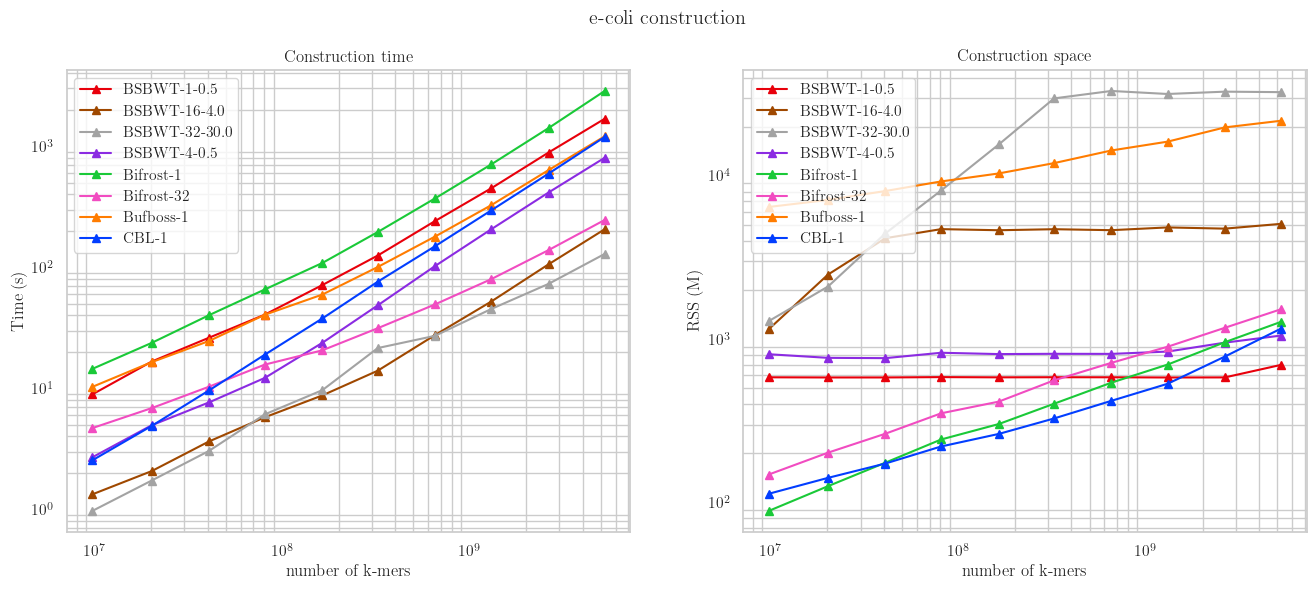

In [7]:
coli_res = read_res("../bbb_res/build_coli.txt")
plot_time_and_space(coli_res["data"], coli_res["offered"], "e-coli construction", "build_e-coli_total.pdf")

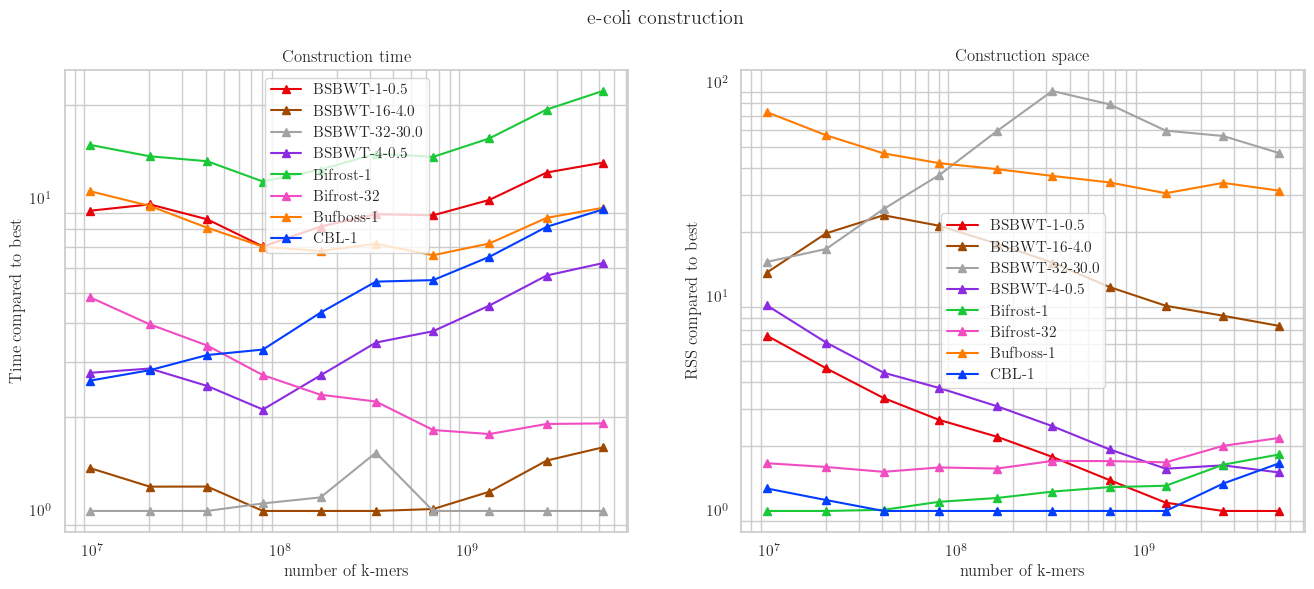

In [8]:
plot_time_and_mem_vs_best(coli_res["data"], coli_res["offered"], "e-coli construction", "build_e-coli_comp.pdf")

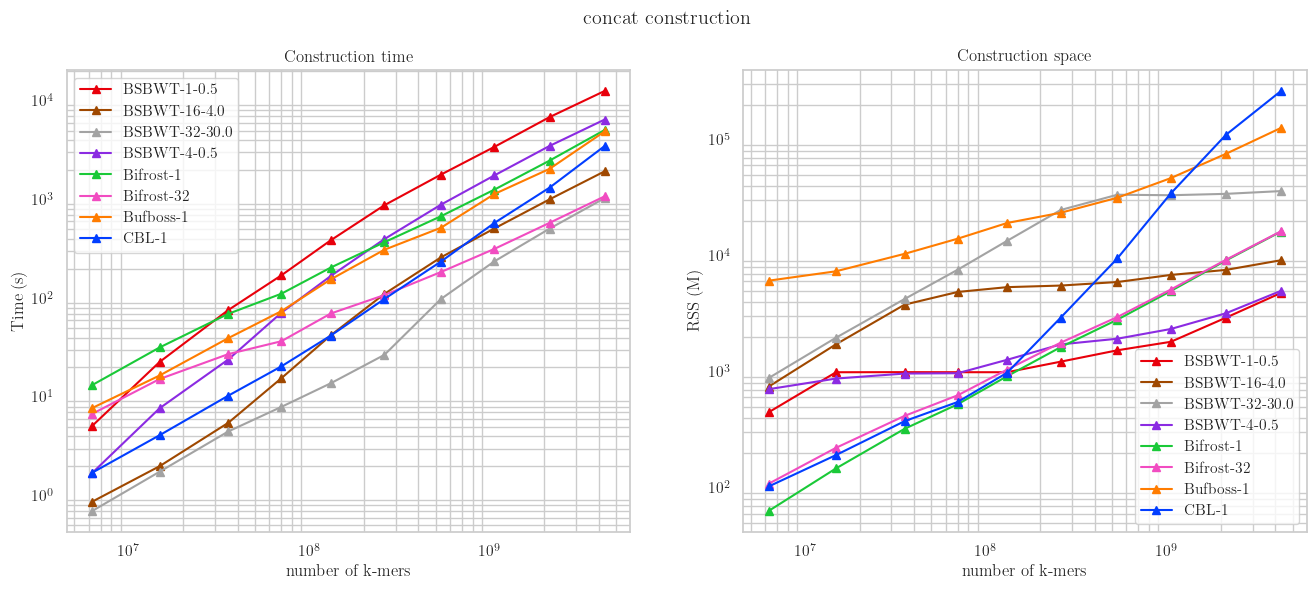

In [9]:
concat_res = read_res("../bbb_res/build_concat.txt")
plot_time_and_space(concat_res["data"], concat_res["offered"], "concat construction", "build_concat_total.pdf")

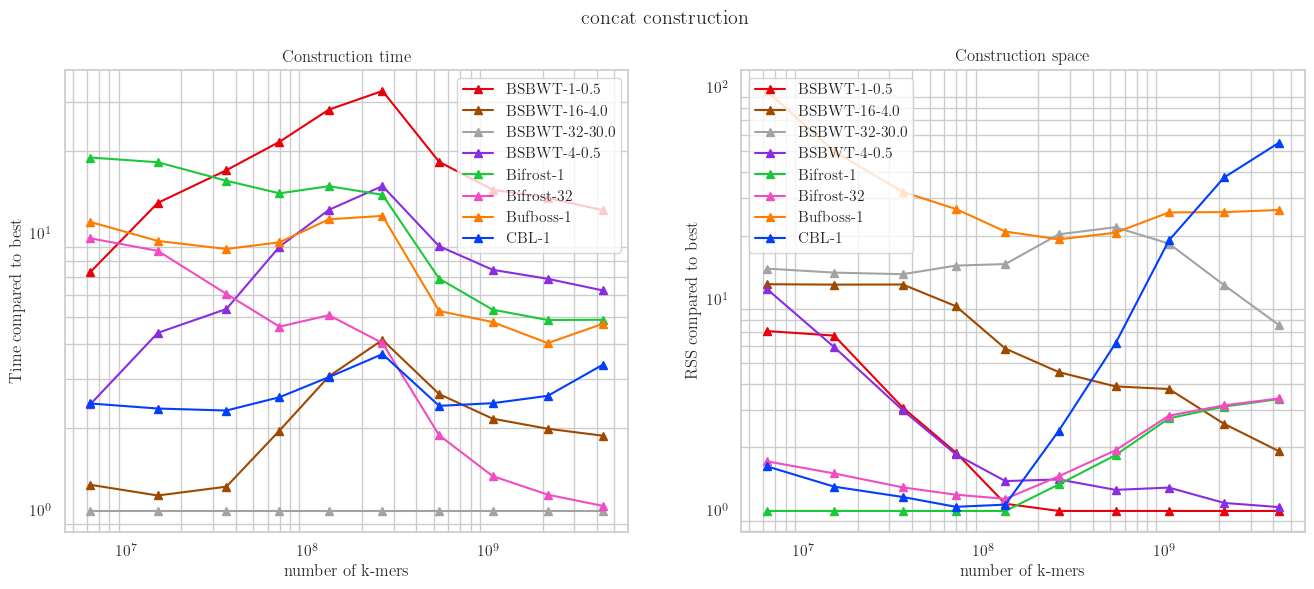

In [10]:
plot_time_and_mem_vs_best(concat_res["data"], concat_res["offered"], "concat construction", "build_concat_comp.pdf")

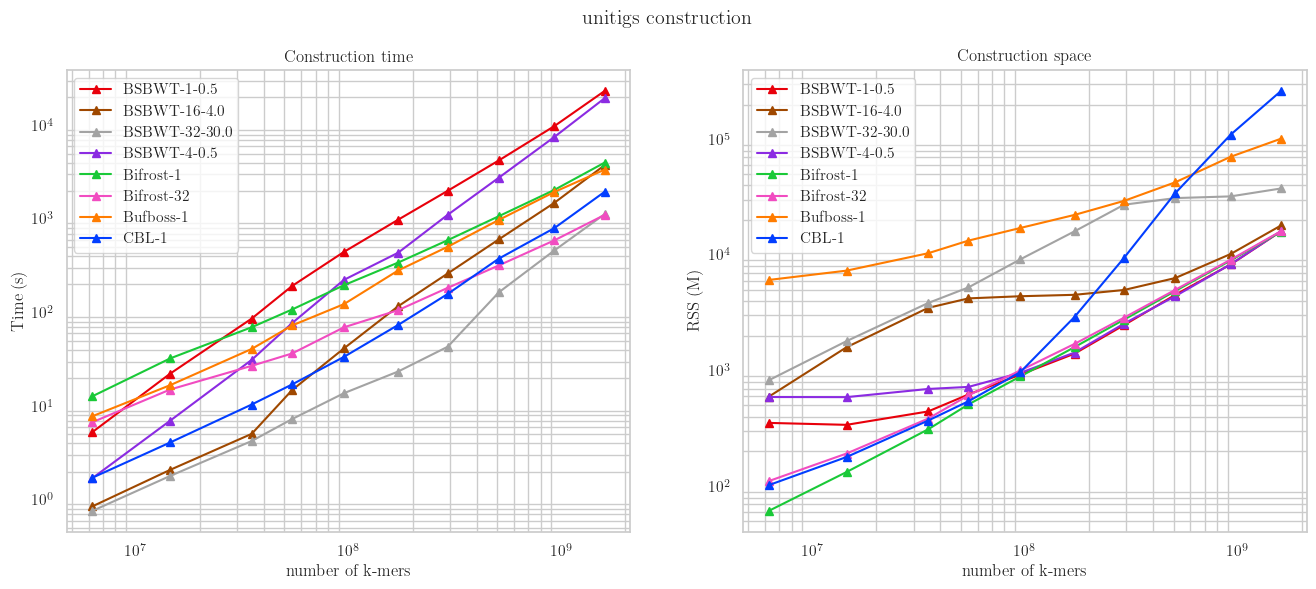

In [11]:
uni_res = read_res("../bbb_res/build_uni.txt")
plot_time_and_space(uni_res["data"], uni_res["offered"], "unitigs construction", "build_uni_total.pdf")

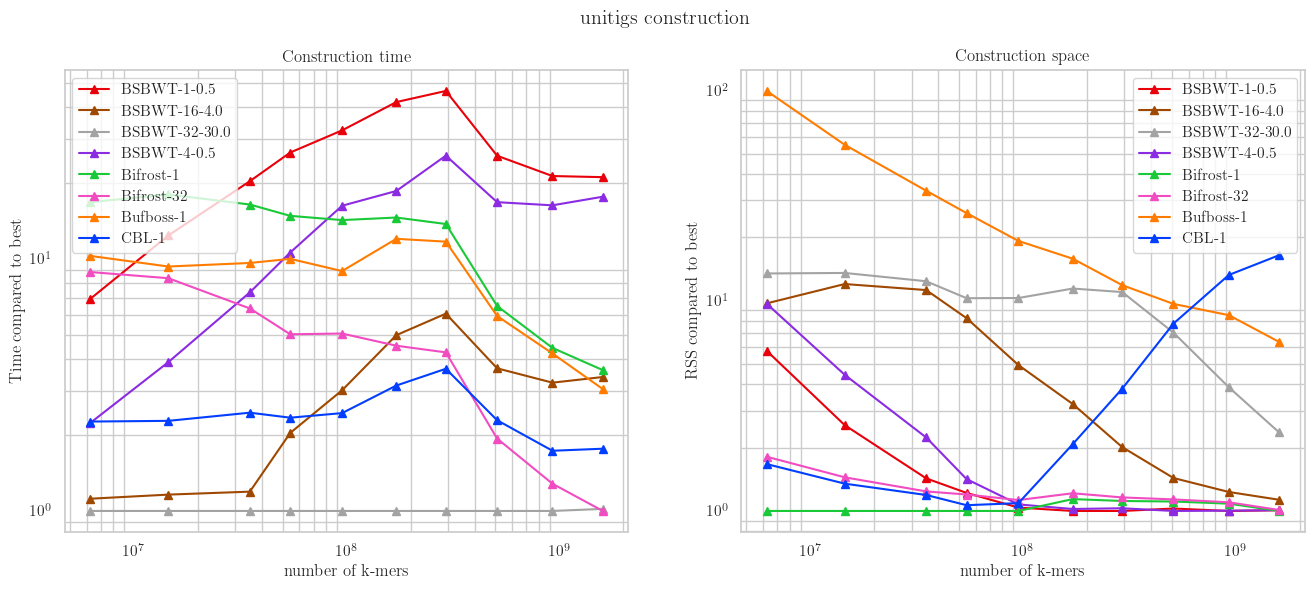

In [12]:
plot_time_and_mem_vs_best(uni_res["data"], uni_res["offered"], "unitigs construction", "build_uni_comp.pdf")

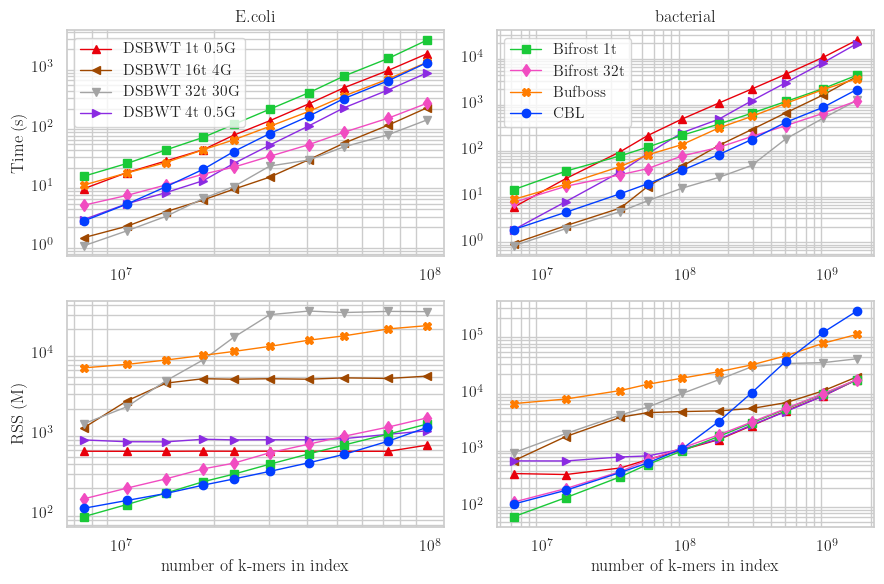

In [13]:
plt.figure(figsize=(9, 6))

for i, (ds, name) in enumerate(zip([coli_res, uni_res], ["E.coli", "bacterial"])):
    plt.subplot(2, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        handles += plt.plot(ds["added"], [vv[0] for vv in v], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Time (s)")
        plt.legend(handles=handles[:4])
    else:
        plt.legend(handles=handles[4:])
    plt.title(name)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(2, 2, i + 3)
    for k, v in sorted(ds["data"].items()):
        plt.plot(ds["added"], [vv[1] for vv in v], linewidth=1,
             color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers in index")
    if i == 0:
        plt.ylabel("RSS (M)")
    #plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
plt.tight_layout()
plt.savefig("build_time_and_space.pdf", bbox_inches="tight")
#plt.show()

In [14]:
[a/ b for a, b in zip(coli_res["offered"], uni_res["offered"])]

[1.5549442460647698,
 1.3869984683341559,
 1.1608086545880483,
 1.4869401398398332,
 1.7211580209769244,
 1.887727083728342,
 2.2307440579037676,
 2.555295017581601,
 2.8357264557107813,
 3.275791701763933]

In [15]:
[a / b for a, b in zip(uni_res["added"], uni_res["offered"])]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [16]:
def f_num(val):
    if val < 10:
        return f"{val:.2f}"
    s_val = f"{val:.2E}".split("+")
    return s_val[0][:-1] + "e" + str(int(s_val[1]))

In [29]:
text = r"\begin{longtable}{ l | "
text += " | ".join("l" for _ in range(10))
text += "}\n\\hline\n"
text += "Genomes \\# & "
text += " & ".join(f"{2**i}" for i in range(1, 11))
text += "\\\\\n"
text += "Total k-mers & "
text += " & ".join(f_num(v) for v in coli_res["offered"])
text += " \\\\\nAdded k-mers & "
text += " & ".join(f_num(v) for v in coli_res["added"])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "RSS (bytes)"], [0, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in coli_res["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\end{longtable}\n"
print(text)

\begin{longtable}{ l | l | l | l | l | l | l | l | l | l | l}
\hline
Genomes \# & 2 & 4 & 8 & 16 & 32 & 64 & 128 & 256 & 512 & 1024\\
Total k-mers & 9.71e6 & 2.01e7 & 4.07e7 & 8.07e7 & 1.64e8 & 3.23e8 & 6.53e8 & 1.30e9 & 2.63e9 & 5.24e9 \\
Added k-mers & 7.55e6 & 1.04e7 & 1.39e7 & 1.84e7 & 2.31e7 & 3.02e7 & 4.04e7 & 5.25e7 & 7.32e7 & 9.75e7 \\
\hline
Total time (s) & & & & & & & & & & \\
CBL & 2.54 & 4.89 & 9.61 & 1.90e1 & 3.78e1 & 7.60e1 & 1.49e2 & 2.95e2 & 5.94e2 & 1.19e3 \\
Bufboss & 1.03e1 & 1.64e1 & 2.46e1 & 4.05e1 & 5.95e1 & 1.00e2 & 1.79e2 & 3.26e2 & 6.35e2 & 1.21e3 \\
Bifrost 1t & 1.45e1 & 2.37e1 & 4.02e1 & 6.55e1 & 1.09e2 & 1.95e2 & 3.70e2 & 7.08e2 & 1.41e3 & 2.86e3 \\
DSBWT 1t 0.5G & 8.90 & 1.66e1 & 2.62e1 & 4.06e1 & 7.13e1 & 1.25e2 & 2.41e2 & 4.49e2 & 8.87e2 & 1.68e3 \\
DSBWT 4t 0.5G & 2.69 & 4.95 & 7.65 & 1.22e1 & 2.38e1 & 4.85e1 & 1.02e2 & 2.06e2 & 4.15e2 & 8.03e2 \\
DSBWT 16t 4G & 1.33 & 2.07 & 3.64 & 5.76 & 8.74 & 1.40e1 & 2.75e1 & 5.21e1 & 1.06e2 & 2.06e2 \\
Bifrost 32t

In [28]:
text = r"\begin{longtable}{ l | "
text += " | ".join("l" for _ in range(10))
text += "}\n\\hline\n"
text += "Genomes \\# & "
text += " & ".join(f"{2**i}" for i in range(1, 11))
text += "\\\\\n\\hline\n\\textbf{Unitigs} \\\\\n\\hline\n"
text += "Total k-mers & "
text += " & ".join(f_num(v) for v in uni_res["offered"])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "RSS (bytes)"], [0, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in uni_res["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\textbf{Concat} \\\\\n\\hline\n"
text += "Total k-mers & "
text += " & ".join(f_num(v) for v in concat_res["offered"])
text += " \\\\\nAdded k-mers & "
text += " & ".join(f_num(v) for v in concat_res["added"])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "RSS (bytes)"], [0, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in concat_res["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\end{longtable}\n"
print(text)

\begin{tabular}{ l | l | l | l | l | l | l | l | l | l | l}
\hline
Genomes \# & 2 & 4 & 8 & 16 & 32 & 64 & 128 & 256 & 512 & 1024\\
\hline
\textbf{Unitigs} \\
\hline
Total k-mers & 6.24e6 & 1.45e7 & 3.51e7 & 5.43e7 & 9.52e7 & 1.71e8 & 2.93e8 & 5.10e8 & 9.28e8 & 1.60e9 \\
\hline
Total time (s) & & & & & & & & & & \\
CBL & 1.72 & 4.10 & 1.04e1 & 1.71e1 & 3.37e1 & 7.39e1 & 1.58e2 & 3.79e2 & 8.00e2 & 1.96e3 \\
Bufboss & 7.81 & 1.68e1 & 4.10e1 & 7.29e1 & 1.23e2 & 2.82e2 & 5.06e2 & 9.81e2 & 1.95e3 & 3.38e3 \\
Bifrost 1t & 1.28e1 & 3.24e1 & 6.98e1 & 1.08e2 & 1.96e2 & 3.43e2 & 5.95e2 & 1.07e3 & 2.05e3 & 4.01e3 \\
DSBWT 1t 0.5G & 5.28 & 2.23e1 & 8.64e1 & 1.93e2 & 4.46e2 & 9.85e2 & 2.00e3 & 4.24e3 & 9.84e3 & 2.34e4 \\
DSBWT 4t 0.5G & 1.70 & 7.01 & 3.13e1 & 7.73e1 & 2.24e2 & 4.37e2 & 1.11e3 & 2.77e3 & 7.53e3 & 1.96e4 \\
DSBWT 16t 4G & 0.85 & 2.09 & 5.07 & 1.49e1 & 4.15e1 & 1.17e2 & 2.62e2 & 6.08e2 & 1.49e3 & 3.77e3 \\
Bifrost 32t & 6.74 & 1.51e1 & 2.70e1 & 3.66e1 & 6.97e1 & 1.06e2 & 1.84e2 & 3.20